<p style="font-size:48px">Lab 7</p>

In [1]:
import numpy as np
import scipy.stats as sp
import pickle
import matplotlib.pyplot as plt

# 1)

In [2]:
# Importing pickle data
with (open("higgs.pkl", "rb")) as openfile:
    higgs = pickle.load(openfile)
with (open("qcd.pkl", "rb")) as openfile:
    qcd = pickle.load(openfile)

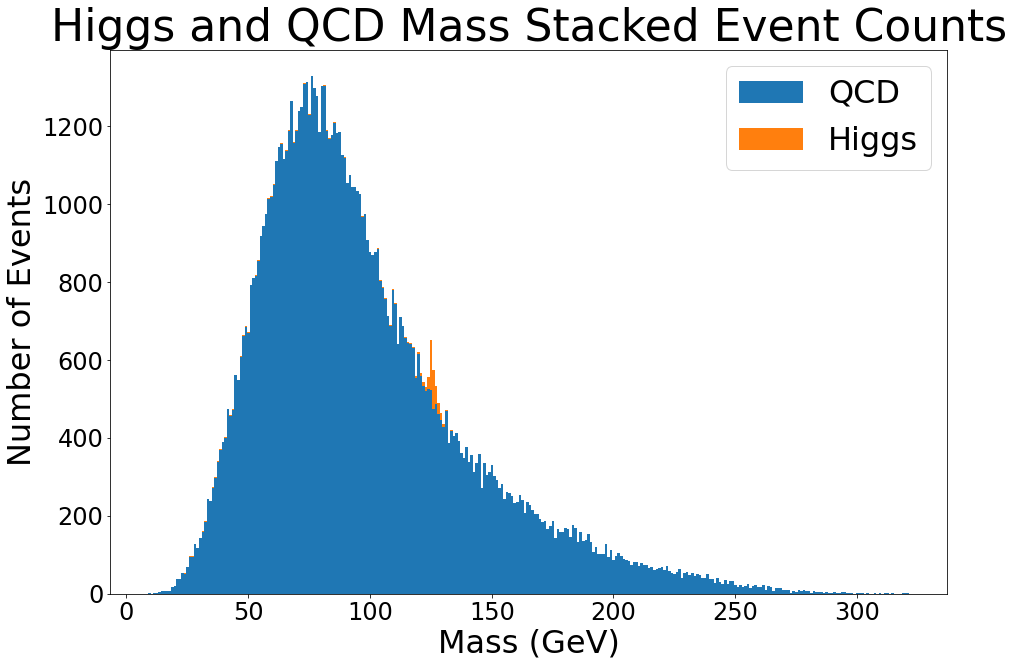

In [3]:
plt.rcParams["figure.figsize"] = (15,10)
plt.hist([qcd['mass'],higgs['mass']], histtype='bar',bins = 300, weights = [np.ones(100000)*20000/20100, np.ones(100000)*100/20100], stacked=True, label = ['QCD', 'Higgs'])
plt.legend(loc="upper right", fontsize = 32)
plt.xlabel('Mass (GeV)', fontsize = 32)
plt.ylabel('Number of Events', fontsize = 32)
plt.title('Higgs and QCD Mass Stacked Event Counts', fontsize = 44)
plt.tick_params(labelsize = 24)
plt.show()

The above graph is a stacked histogram of the QCD mass distribution and the Miggs measurement mass. Here we are adding the densities of the two instead of the raw number of events. It is important to note in this case ```qcd``` and ```higgs``` are the same size. This might not always be the case, and we would need to scale them to be the same size in order for this stacking to produce an accurate distribution. Here we do end up weighting our histograms, as a higgs event is a very rare event, and thus has a very small impact on the total distribution. All of this results in a new probability distribution for the Higgs particle in conjunction with the background. We can see our now very small characteristic peak around 125 GeV from the Higgs distribution, as well as a very large and much wider, peak around 75 GeV from our background distribution.

In [4]:
print('We calculate a significance of {} sigma, compared to our estimate of {}.'.format(
    str(-sp.norm.ppf(sp.poisson.sf(20100, 20000))), str(100 / np.sqrt(20000))
))

We calculate a significance of 0.7112259282313185 sigma, compared to our estimate of 0.7071067811865475.


In the above calculation, we compare our estimated significance to our calculated one. We see that they are very close. Our calculated significance starts by finding the probability of finding a signal of 20100 or more with a Poisson distribution with a mean of 20000. This is because $\mu_{QCD} = 20000$ and $mu_{Higgs} = 100$. Here the hypothetical poisson we are making has a combined mean, $\mu = \mu_{Higgs} + \mu_{QCD} = 20100$. We take this probability use it to find the sigma value from a Gaussian with 0 mean and 1 stanard deviation. This gives us a value of roughly -0.711. Since the Gaussian is symmetric, we can invert this value to have roughly a significance value of 0.711. This is very comprable to our estimated significance of 0.707.

# 2)

In [18]:
def slice_data(data,start,stop):
    sliced = list(filter(lambda l: l >= start and l < stop, data))
    return sliced

In this section we are looking for a range of data to remove to maximize the significance of our signal. The way we want to cut the data is such that we maximize the ratio of background data cut to Higgs data cut. This might mean cutting some Higgs data, so long as we cut proportionally more background data. The reason this ration is important is because this ratio is used to weight the data. The reason we wish to cut in this manner is to maximize $\frac{N_{Higgs}}{\sqrt{N_{QCD}}}$, which is a rough estimate of significance. This means we need to maximize the amount of Higgs and minimize the amount of QCD. 

We know that we want our cut to be roughly centered on 125, as there is a large spike for the Higgs dataset there. Using the below graph, we can see that our cut should be mostly symmetric, with slightly more of the left cut out than the right, as the the distribution trails off slower on the right side than the left.

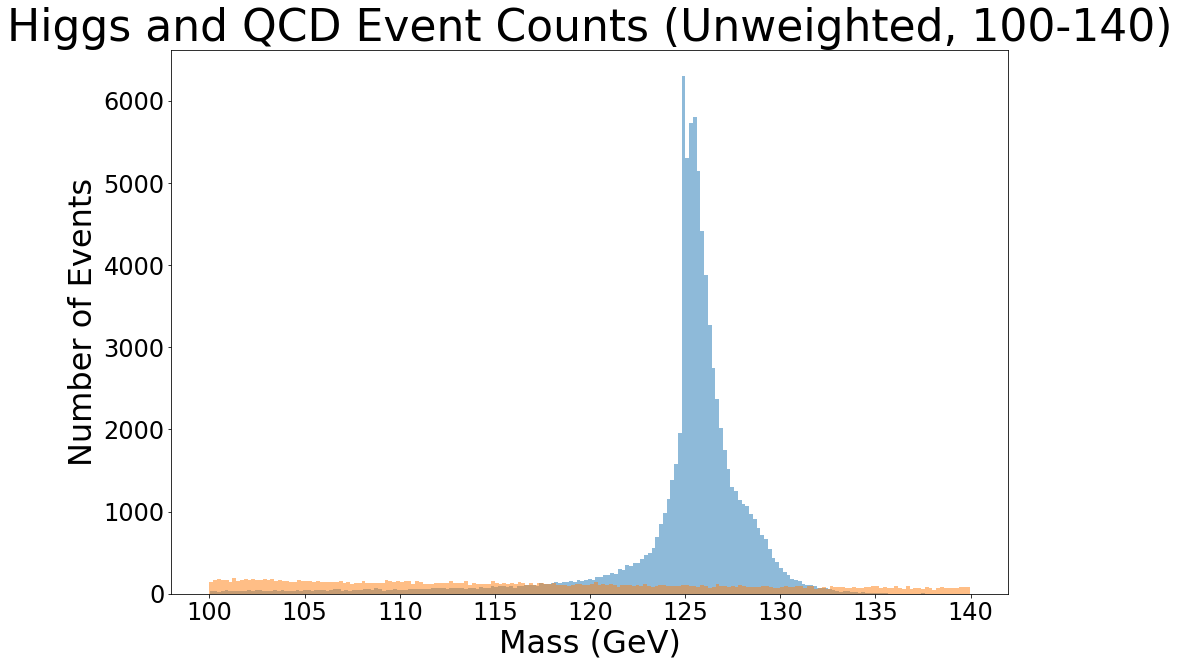

In [42]:
plt.rcParams["figure.figsize"] = (15,10)
plt.hist(slice_data(higgs['mass'], 100, 140), bins = 200, alpha = 0.5)
plt.hist(slice_data(qcd['mass'], 100, 140), bins = 200, alpha = 0.5)
plt.xlabel('Mass (GeV)', fontsize = 32)
plt.ylabel('Number of Events', fontsize = 32)
plt.title('Higgs and QCD Event Counts (Unweighted, 100-140)', fontsize = 44)
plt.tick_params(labelsize = 24)
plt.show()

In [30]:
# Find min bound
minBound = 0
minRatio = 0
for i in range(100,121):
    # Count the number of events between i and 125
    # 120 was chosen to presevere a significant amount of data
    qcd_count = 0
    higgs_count = 0
    for higgs_event, qcd_event in zip(higgs['mass'], qcd['mass']):
        if higgs_event > i and higgs_event <= 125:
            higgs_count += 1
        if qcd_event > i and qcd_event <= 125:
            qcd_count += 1
            
    # Check if the ratio is higher than the previous best
    if minRatio < (higgs_count / qcd_count):
        minRatio = (higgs_count / qcd_count)
        minBound = i
        
# Find max bound
maxBound = 0
maxRatio = 0
for i in range(130,140):
    # Count the number of events between 125 and i
    # 127 was chosen to presevere a significant amount of data
    qcd_count = 0
    higgs_count = 0
    for higgs_event, qcd_event in zip(higgs['mass'], qcd['mass']):
        if higgs_event < i and higgs_event > 125:
            higgs_count += 1
        if qcd_event < i and qcd_event > 125:
            qcd_count += 1
            
    # Check if the ratio is higher than the previous best
    if maxRatio < (higgs_count / qcd_count):
        maxRatio = (higgs_count / qcd_count)
        maxBound = i
print(minBound)
print(maxBound)

120
130


We can see in the above code, that the most optimal way to cut the data while still preseving it would be to cut at 120 and 130. It makes sense that it would want to cut at these bounds, as getting closer to 125, where we have a significant peak, we see that there is more and more data, while the QCD events don't change much. This means that a we tighten our range around 125, we also maximize our ratio of Higgs events to QCD events. Moving forward, we will start with a cut between 119 and 127. 

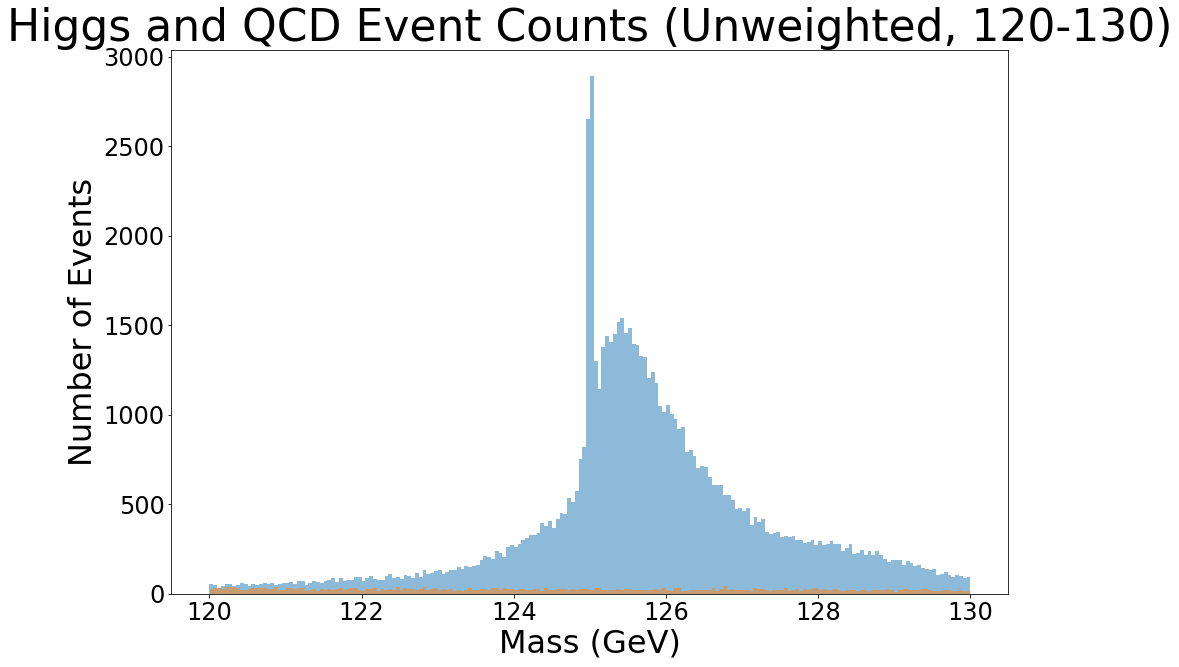

In [41]:
plt.rcParams["figure.figsize"] = (15,10)
plt.hist(slice_data(higgs['mass'], 120, 130), bins = 200, alpha = 0.5)
plt.hist(slice_data(qcd['mass'], 120, 130), bins = 200, alpha = 0.5)
plt.xlabel('Mass (GeV)', fontsize = 32)
plt.ylabel('Number of Events', fontsize = 32)
plt.title('Higgs and QCD Event Counts (Unweighted, 120-130)', fontsize = 44)
plt.tick_params(labelsize = 24)
plt.show()

In [49]:
n_higgs = 100
n_qcd = 20000
norm = (sum(slice_data(higgs['mass'], 120, 130)) / sum(qcd['mass'])) * n_higgs
background_norm = (sum(slice_data(qcd['mass'], 120, 130)) / sum(qcd['mass'])) * n_qcd
sigma = np.abs(norm / np.sqrt(background_norm))
print("With a cut at {} and {}, we now have a sigma of {}.".format('120','130',sigma))

With a cut at 120 and 130, we now have a sigma of 2.7590221841506133.


Cutting at 119 and 127 clearly increased our significance of our measurement, bumping it all the way up to nearly 2.5 $\sigma$. This is a remarkable 3x increase, but we are still short of that illustrious 5 $\sigma$ required for a discovery. From here we will try cutting from the left and the right. Given the distribution of the data, we can see that we will cut roughly equal amounts of the QCD from both sides, however we will cut far less of the Higgs from the left side. This means that cutting from the left will have a much greater impact than cutting from the right.

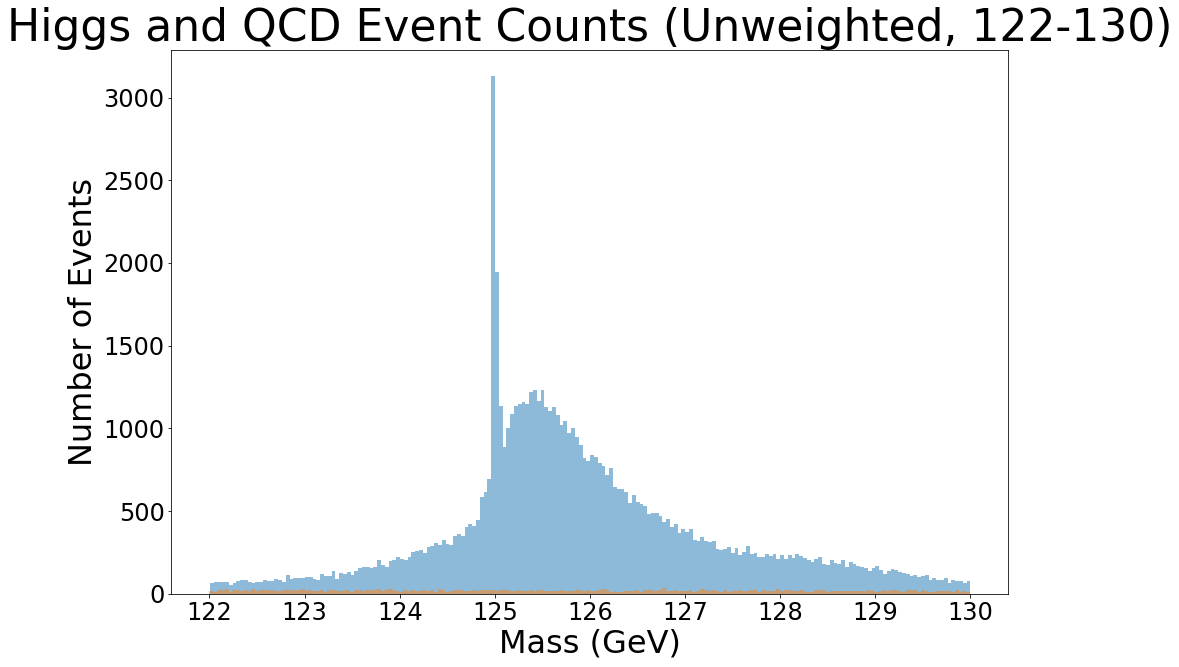

In [46]:
plt.rcParams["figure.figsize"] = (15,10)
plt.hist(slice_data(higgs['mass'], 122, 130), bins = 200, alpha = 0.5)
plt.hist(slice_data(qcd['mass'], 122, 130), bins = 200, alpha = 0.5)
plt.xlabel('Mass (GeV)', fontsize = 32)
plt.ylabel('Number of Events', fontsize = 32)
plt.title('Higgs and QCD Event Counts (Unweighted, 122-130)', fontsize = 44)
plt.tick_params(labelsize = 24)
plt.show()

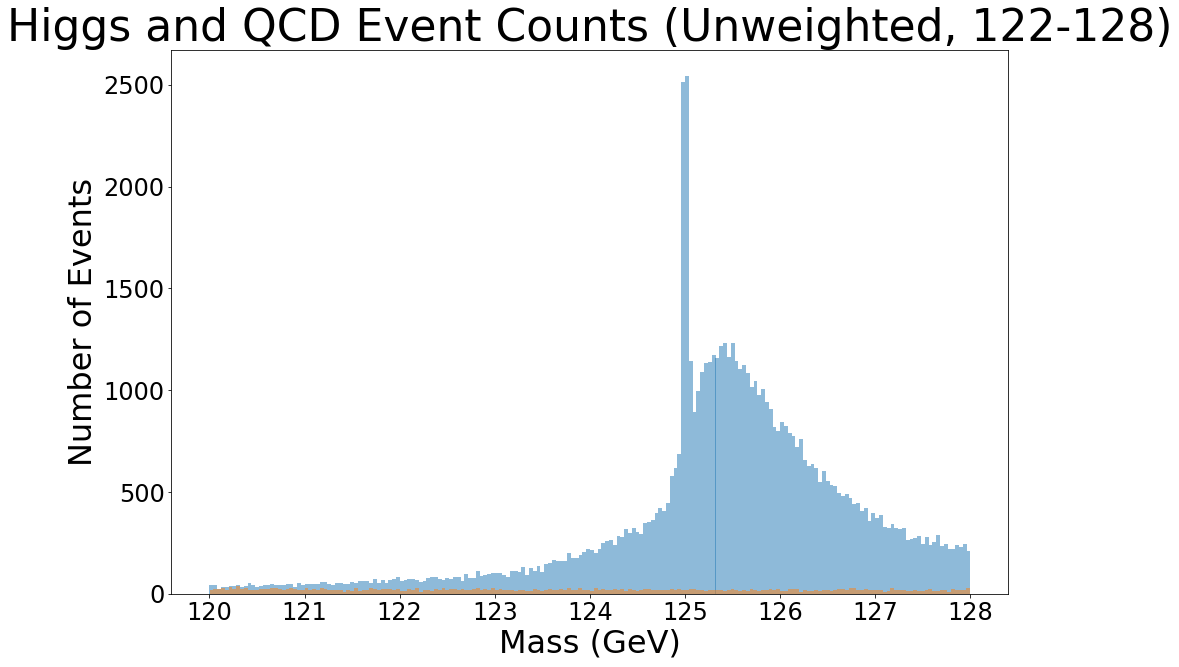

In [43]:
plt.rcParams["figure.figsize"] = (15,10)
plt.hist(slice_data(higgs['mass'], 120, 128), bins = 200, alpha = 0.5)
plt.hist(slice_data(qcd['mass'], 120, 128), bins = 200, alpha = 0.5)
plt.xlabel('Mass (GeV)', fontsize = 32)
plt.ylabel('Number of Events', fontsize = 32)
plt.title('Higgs and QCD Event Counts (Unweighted, 122-128)', fontsize = 44)
plt.tick_params(labelsize = 24)
plt.show()

In [47]:
n_higgs = 100
n_qcd = 20000
norm = (sum(slice_data(higgs['mass'], 120, 128)) / sum(qcd['mass'])) * n_higgs
background_norm = (sum(slice_data(qcd['mass'], 120, 128)) / sum(qcd['mass'])) * n_qcd
sigma = np.abs(norm / np.sqrt(background_norm))
print("With a cut at {} and {}, we now have a sigma of {}.".format('120','128',sigma))

With a cut at 120 and 128, we now have a sigma of 2.733758981389014.


In [48]:
n_higgs = 100
n_qcd = 20000
norm = (sum(slice_data(higgs['mass'], 122, 130)) / sum(qcd['mass'])) * n_higgs
background_norm = (sum(slice_data(qcd['mass'], 122, 130)) / sum(qcd['mass'])) * n_qcd
sigma = np.abs(norm / np.sqrt(background_norm))
print("With a cut at {} and {}, we now have a sigma of {}.".format('122','130',sigma))

With a cut at 122 and 130, we now have a sigma of 3.0299351849376186.


Although we cut 2 from each side, we can clearly see that removing from the left had a greater impact, due to the fact that the data we removed from the left had a greater ratio of QCD to Higgs. This resulted in a jump in 0.3 $\sigma$ while cutting from the right actually saw a drop in about 0.02 $\sigma$